In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_absolute_percentage_error

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

In [2]:
df = pd.read_excel('train.xlsx')

In [3]:
df = df.drop(['Unnamed: 0', '№ брони','Способ оплаты'], axis=1)
df['В какой час бронировали'] = (df['Дата бронирования'].dt.hour + 2) % 24
df['За сколько часов до заезда бронь'] = (df['Заезд'] - df['Дата бронирования']).dt.total_seconds() // 3600 #насколько рано бронь
df = df.drop(['Дата бронирования', 'Заезд','Выезд'], axis=1) # уберем ненужные столбцы

In [4]:
for col in ['Источник']:
    df = pd.concat([df, pd.get_dummies(df[col])], axis=1)
    df = df.drop(col, axis=1)
df['Бронь с официального сайта'] = df['Официальный сайт']
df['Бронь со специальных сайтов'] = df['Bronevik.com(new)'] + df['booking.com'] + df['Бронирование из экстранета'] + df['Zabroniryi.ru'] + df['OneTwoTrip'] + df['ostrovok.ru']  + df['booking.com (Booking.com)']+ df['Acase.ru (ООО "АКАДЕМ-ОНЛАЙН")']+ df['Acase.ru (ООО "ПРАНДИУМ")']+ df['Alean.ru (13.10.2023-02.06.2025)']+ df['Alean.ru (03.02.2022-31.01.2023)']+ df['101hotels.com']+ df['Acase.ru (ООО "КАЛЕЙДОСКОП")']+ df['Otello'] + df['expedia.com (A-Hotels.com)']+ df['Alean.ru (31.10.2023-22.06.2025)'] + df['Svoy Hotel']+ df['Alean.ru (20.01.2021-31.01.2022)']
df['Бронь по лояльности'] = df['Программа лояльности'] + df['Cuva']
df['Бронь с гигантов'] = df['Яндекс.Путешествия'] + df['Тинькофф Путешествия'] + df['Ozon'] + df['ВКонтакте']

for col in ['Яндекс.Путешествия', 'Официальный сайт', 'Bronevik.com(new)',
       'booking.com', 'Бронирование из экстранета', 'Zabroniryi.ru',
       'OneTwoTrip', 'ostrovok.ru', 'Программа лояльности', 'Cuva',
       'booking.com (Booking.com)', 'Acase.ru (ООО "АКАДЕМ-ОНЛАЙН")',
       'Acase.ru (ООО "ПРАНДИУМ")', 'Alean.ru (13.10.2023-02.06.2025)',
       'Alean.ru (03.02.2022-31.01.2023)', '101hotels.com',
       'Acase.ru (ООО "КАЛЕЙДОСКОП")', 'Alean.ru (16.01.2023-06.09.2024)',
       'Bronevik.com/Bro.Online', 'Тинькофф Путешествия', 'ВКонтакте',
       'Otello', 'expedia.com (A-Hotels.com)', 'Ozon',
       'Alean.ru (31.10.2023-22.06.2025)', 'Svoy Hotel',
       'Alean.ru (20.01.2021-31.01.2022)']:
    df = df.drop(col, axis=1)

df

,Номеров,Стоимость,Внесена предоплата,Дата отмены,Ночей,Статус брони,Категория номера,Гостей,Гостиница,В какой час бронировали,За сколько часов до заезда бронь,Бронь с официального сайта,Бронь со специальных сайтов,Бронь по лояльности,Бронь с гигантов
0,1,25700.0,0,2023-04-20 20:39:15,3,Отмена,Номер «Стандарт»,2,1,22,186.0,False,False,False,True
1,1,24800.0,12400,NaT,2,Активный,Номер «Стандарт»,2,1,16,552.0,True,False,False,False
2,1,25800.0,12900,NaT,2,Активный,Номер «Студия»,2,4,0,472.0,True,False,False,False
3,1,10500.0,0,NaT,1,Активный,Номер «Стандарт»,1,3,17,239.0,False,True,False,False
4,1,28690.0,28690,NaT,2,Активный,Номер «Люкс»,4,1,21,211.0,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26169,1,18240.0,9120,NaT,2,Активный,Номер «Стандарт»,2,2,19,1485.0,True,False,False,False
26170,1,69600.0,23200,NaT,3,Активный,Номер «Студия»,3,4,19,117.0,True,False,False,False
26171,1,55600.0,13900,NaT,4,Активный,Номер «Стандарт»,2,2,21,1123.0,True,False,False,False
26172,1,6300.0,0,2022-04-16 23:14:35,1,Отмена,Номер «Стандарт»,2,3,11,1613.0,False,True,False,False


In [5]:
df['Факт отмены'] = (df['Статус брони'] != 'Активный').astype(int)
#df = df[df['Статус брони'] != 'Неподтвержденные']
#df.loc[df['Дата отмены'].isna(), 'Факт отмены'] = 0
#df.loc[df['Дата отмены'].notna(),'Факт отмены'] = 1
df = df.drop(['Дата отмены', 'Статус брони'], axis=1)

#df = df[df['Стоимость'] > 1000]

In [6]:
categories = np.array(['Номер «Стандарт»', 'Номер «Студия»', 'Номер «Люкс»',
       'Апартаменты с 2 спальнями с отдельным входом',
       'Коттедж с 3 спальнями',
       'Коттедж с 2 спальнями',
       'Номер «Стандарт» для маломобильных групп населения'])

# Create new columns with all zeros
for cat in categories:
    df[cat] = 0

for index, row in df.iterrows():
    for cat in categories:
        if cat in row['Категория номера']:
            df.loc[index, cat] = 1  # Set the value to 1 if category is present

for col in ['Категория номера']:
    df = df.drop(col, axis=1)

df.dtypes

Номеров                                                 int64
Стоимость                                             float64
Внесена предоплата                                      int64
Ночей                                                   int64
Гостей                                                  int64
Гостиница                                               int64
В какой час бронировали                                 int32
За сколько часов до заезда бронь                      float64
Бронь с официального сайта                               bool
Бронь со специальных сайтов                              bool
Бронь по лояльности                                      bool
Бронь с гигантов                                         bool
Факт отмены                                             int32
Номер «Стандарт»                                        int64
Номер «Студия»                                          int64
Номер «Люкс»                                            int64
Апартаме

In [7]:
# делим выборку на обучающую и валидационную c CountVectorizer
df = df.rename(str, axis="columns")
X_train, X_val, y_train, y_val = train_test_split(df.drop("Факт отмены", axis = 1), df["Факт отмены"],
                                                                  random_state = 42,
                                                                  stratify = df["Факт отмены"],
                                                                  test_size = 0.1)
df = df.drop("Факт отмены", axis = 1)



In [167]:
model = LogisticRegression()#создание модели
model.fit(X_train, y_train) #обучение на тренировочном наборе
print(roc_auc_score(model.predict(X_val), y_val))# cчитаем метрику качества auc-roc 0.5- полное говно 1 - идеальная модель

0.7712774374918548


C:\Users\ilyas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [67]:
df

,Номеров,Стоимость,Внесена предоплата,Ночей,Гостей,Гостиница,В какой час бронировали,За сколько часов до заезда бронь,Бронь с официального сайта,Бронь со специальных сайтов,Бронь по лояльности,Бронь с гигантов,Номер «Стандарт»,Номер «Студия»,Номер «Люкс»,Апартаменты с 2 спальнями с отдельным входом,Коттедж с 3 спальнями,Коттедж с 2 спальнями,Номер «Стандарт» для маломобильных групп населения
0,1,25700.0,0,3,2,1,22,186.0,False,False,False,True,1,0,0,0,0,0,0
1,1,24800.0,12400,2,2,1,16,552.0,True,False,False,False,1,0,0,0,0,0,0
2,1,25800.0,12900,2,2,4,0,472.0,True,False,False,False,0,1,0,0,0,0,0
3,1,10500.0,0,1,1,3,17,239.0,False,True,False,False,1,0,0,0,0,0,0
4,1,28690.0,28690,2,4,1,21,211.0,True,False,False,False,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26169,1,18240.0,9120,2,2,2,19,1485.0,True,False,False,False,1,0,0,0,0,0,0
26170,1,69600.0,23200,3,3,4,19,117.0,True,False,False,False,0,1,0,0,0,0,0
26171,1,55600.0,13900,4,2,2,21,1123.0,True,False,False,False,1,0,0,0,0,0,0
26172,1,6300.0,0,1,2,3,11,1613.0,False,True,False,False,1,0,0,0,0,0,0


<BarContainer object of 19 artists>

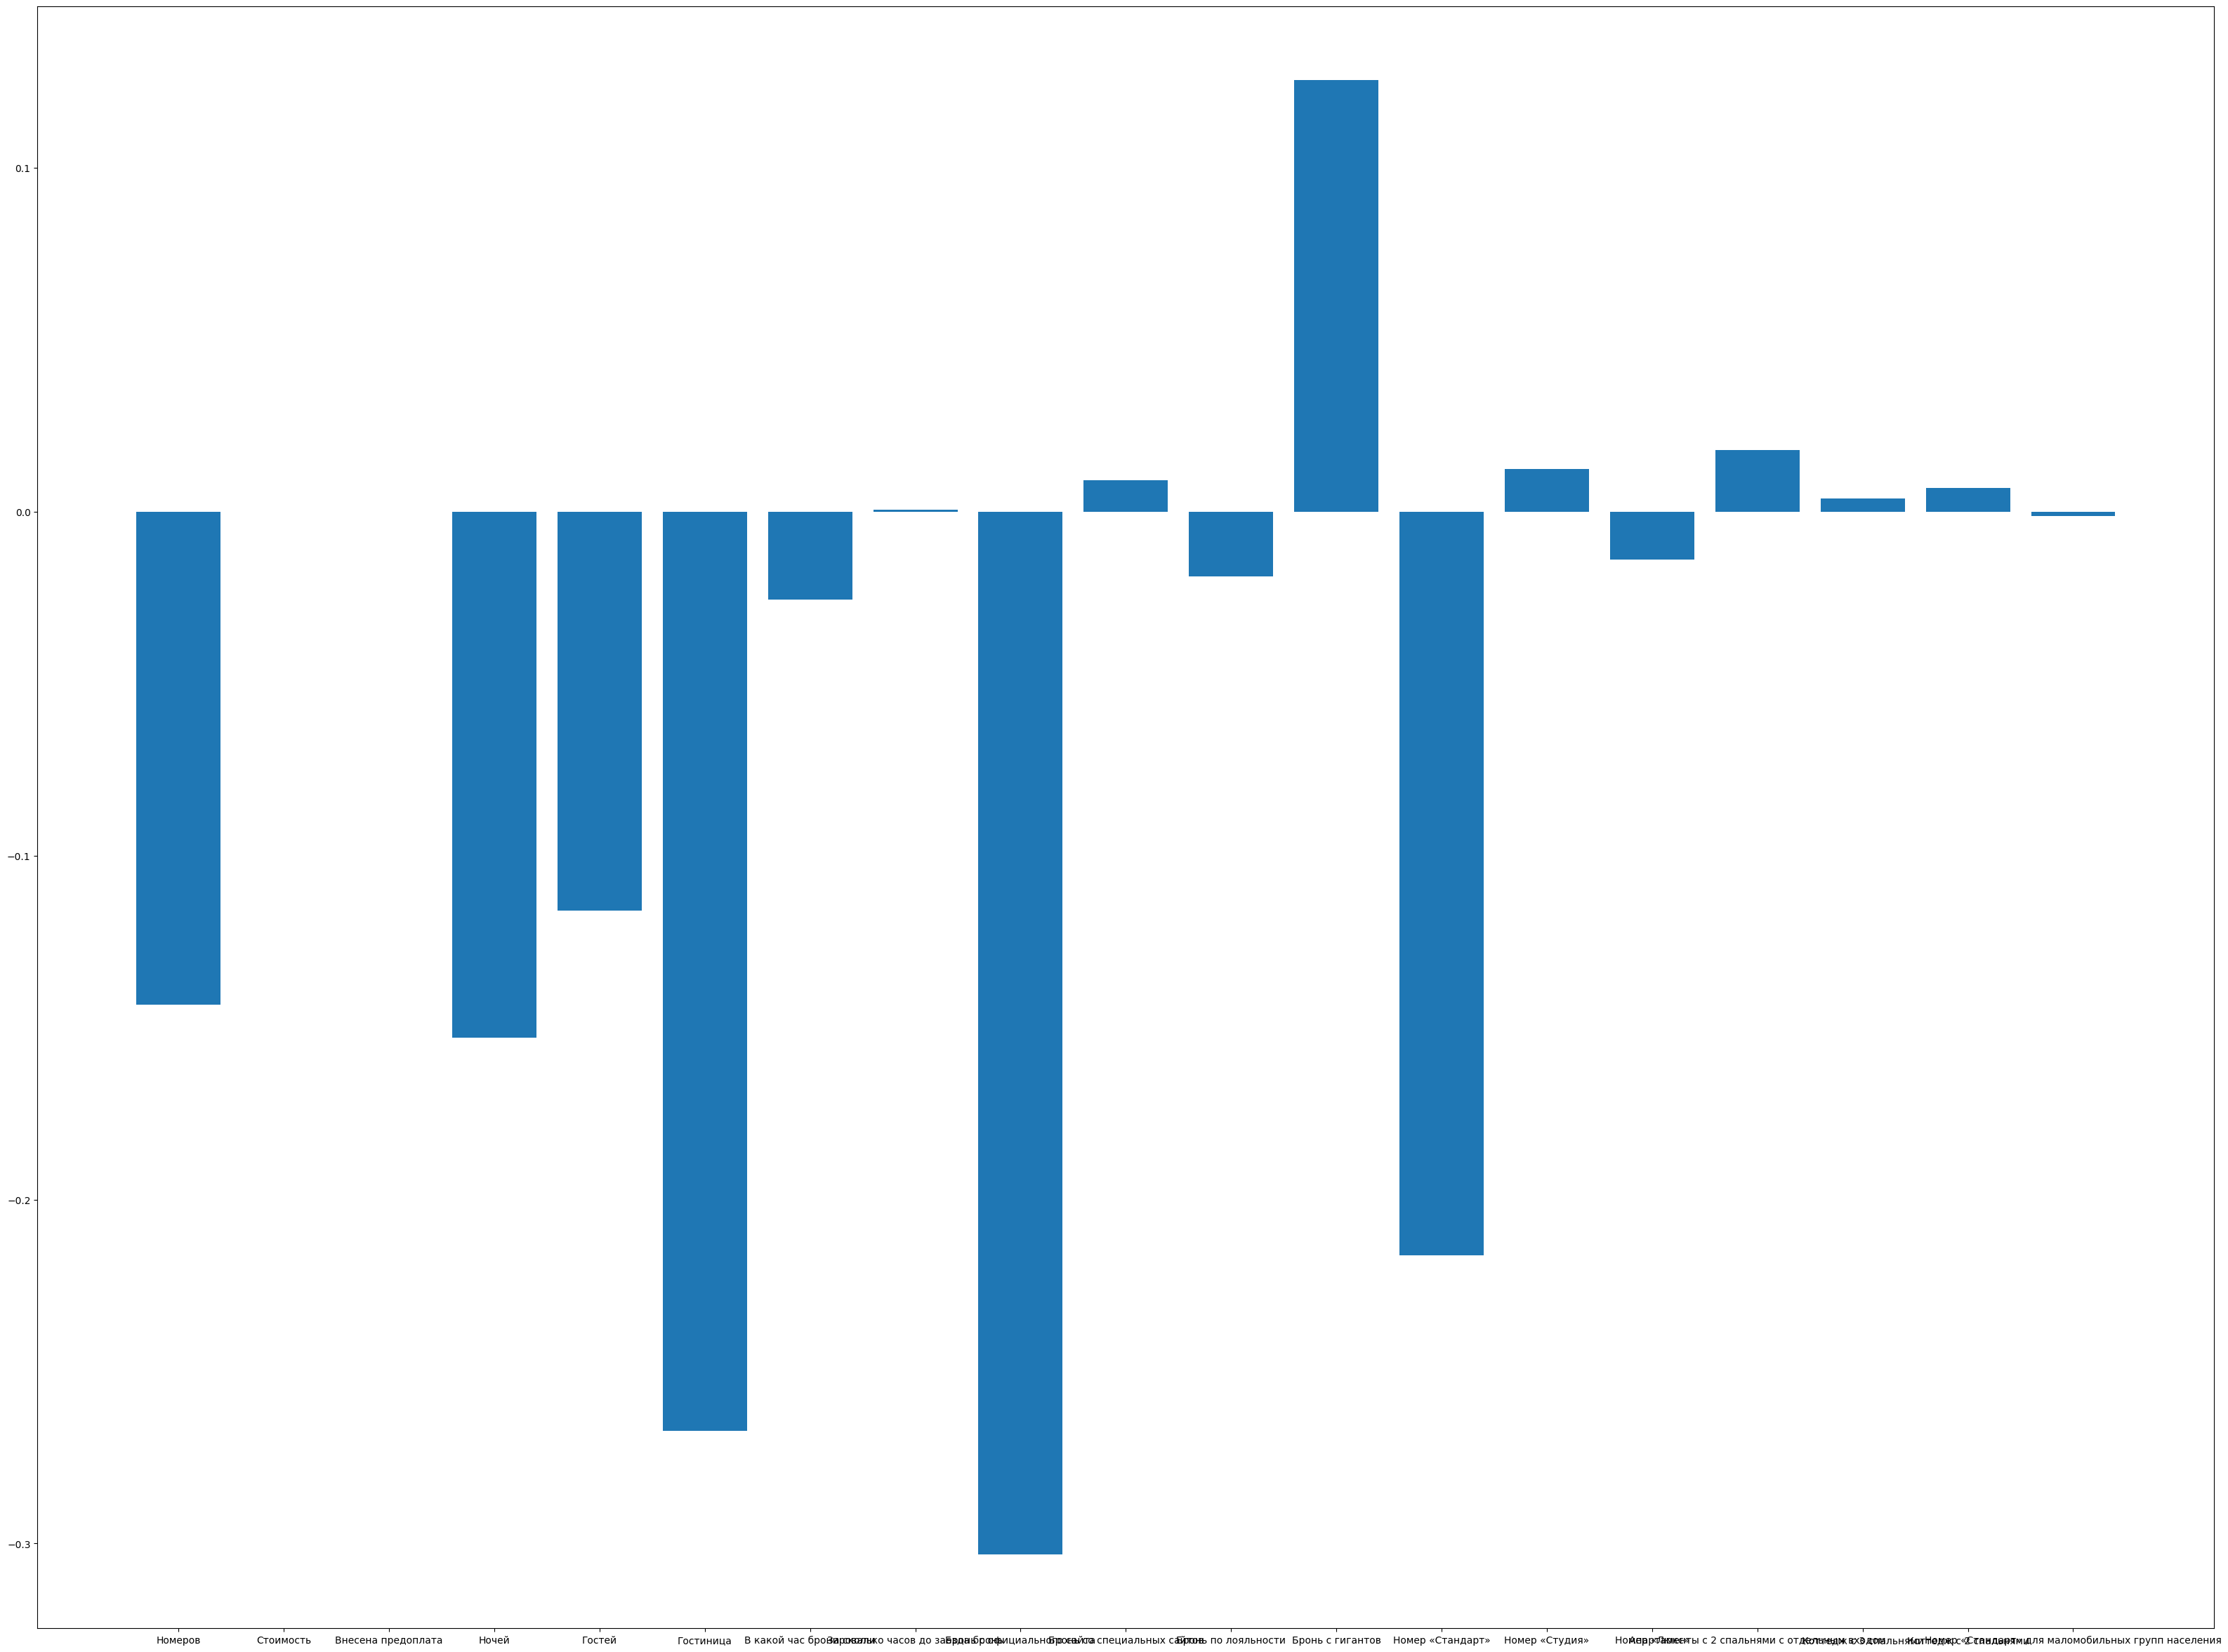

In [110]:
plt.figure(figsize=(40, 30))
plt.bar(df.columns, model.coef_.ravel())

In [111]:
plt.figure(figsize=(40, 30))
print(df.columns, model.coef_.ravel())

Index(['Номеров', 'Стоимость', 'Внесена предоплата', 'Ночей', 'Гостей',
       'Гостиница', 'В какой час бронировали',
       'За сколько часов до заезда бронь', 'Бронь с официального сайта',
       'Бронь со специальных сайтов', 'Бронь по лояльности',
       'Бронь с гигантов', 'Номер «Стандарт»', 'Номер «Студия»',
       'Номер «Люкс»', 'Апартаменты с 2 спальнями с отдельным входом',
       'Коттедж с 3 спальнями', 'Коттедж с 2 спальнями',
       'Номер «Стандарт» для маломобильных групп населения'],
      dtype='object') [-1.43353294e-01  1.15641945e-05 -3.02525109e-05 -1.52992228e-01
 -1.15943855e-01 -2.67332479e-01 -2.55737255e-02  6.79919334e-04
 -3.03238975e-01  9.14615517e-03 -1.88077652e-02  1.25512822e-01
 -2.16185873e-01  1.25213018e-02 -1.38642834e-02  1.80143892e-02
  3.80759511e-03  6.90224381e-03 -1.14605375e-03]


<Figure size 4000x3000 with 0 Axes>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.8943445945945945


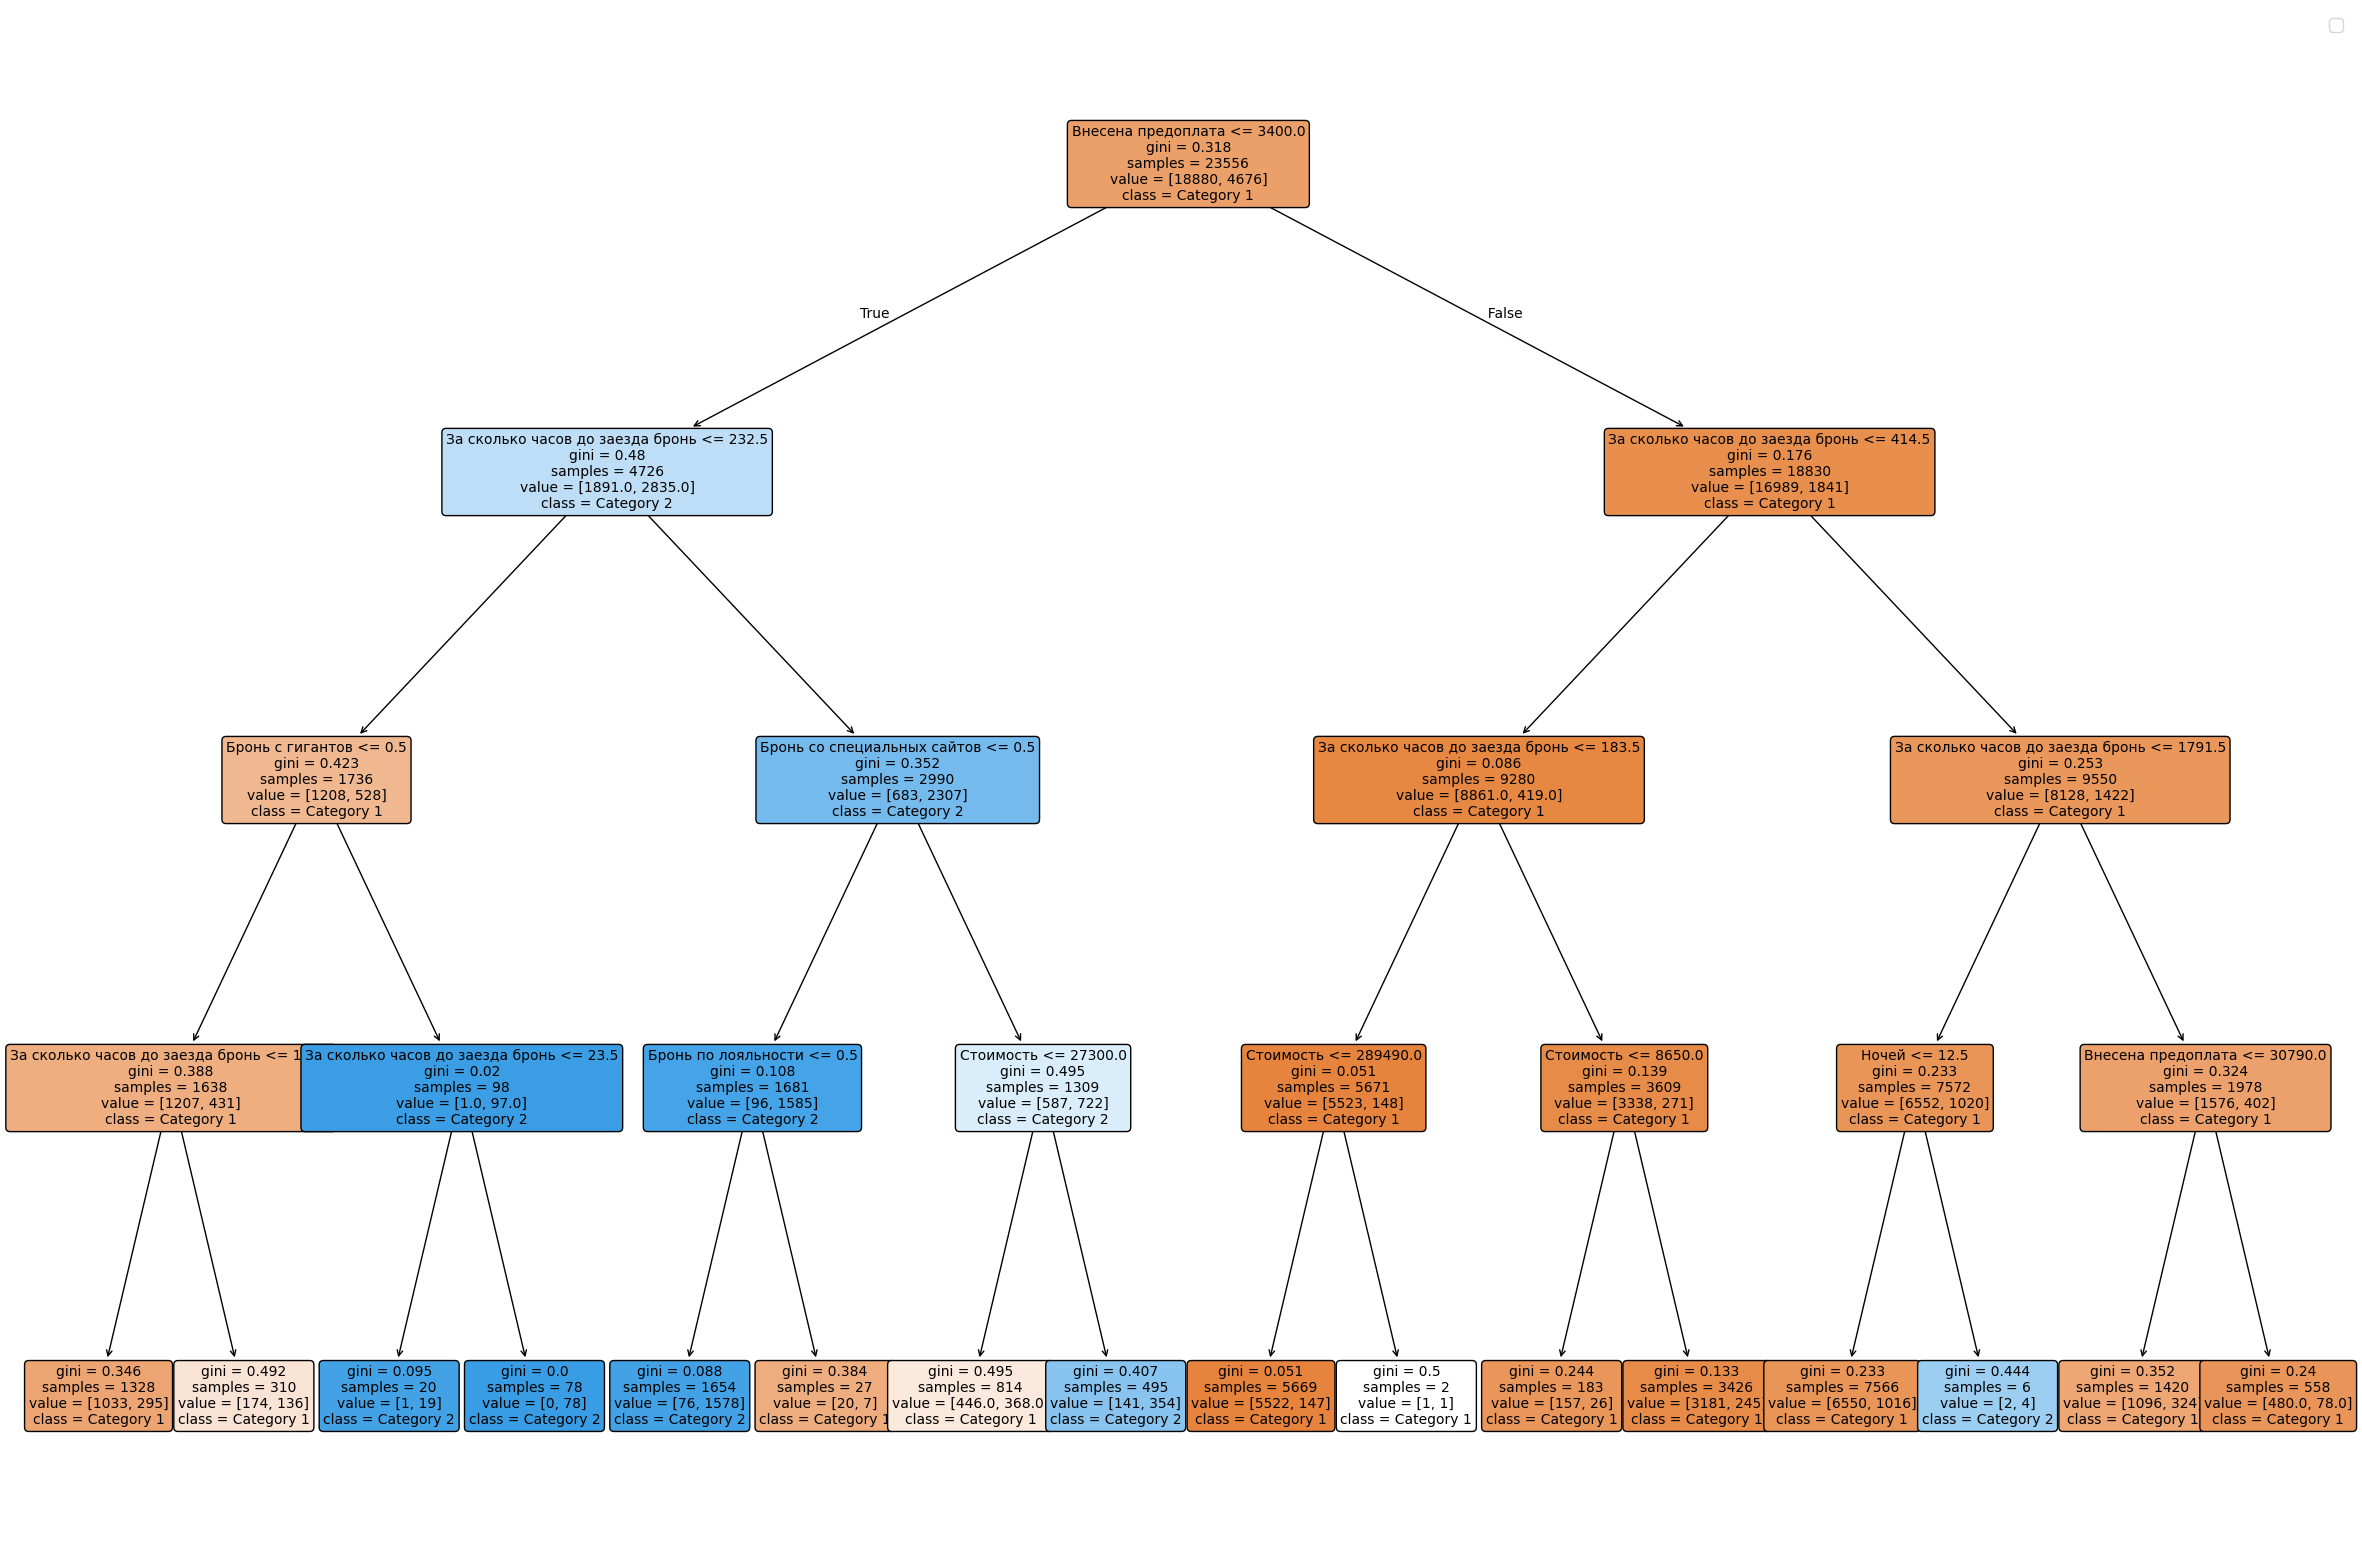

In [9]:
model = DecisionTreeClassifier(max_depth = 4)
model.fit(X_train, y_train) 
print(roc_auc_score(model.predict(X_val), y_val))


from sklearn.tree import plot_tree

# ... (rest of the code remains the same)

plt.figure(figsize=(30, 20))
a = plot_tree(model, 
              feature_names=X_train.columns, 
              class_names=['Category 1', 'Category 2', ...],  # replace with your category names
              filled=True, 
              rounded=True, 
              fontsize=10)

# Add a legend to the plot
plt.legend(loc='upper right', fontsize=12)

# Show the plot
plt.show()
#plt.figure(figsize=(20, 20))
#a=plot_tree(model)
#score = model.predict(df.rename(str, axis="columns"))
#np.savetxt("tr22.csv", score, delimiter=",")

<BarContainer object of 19 artists>

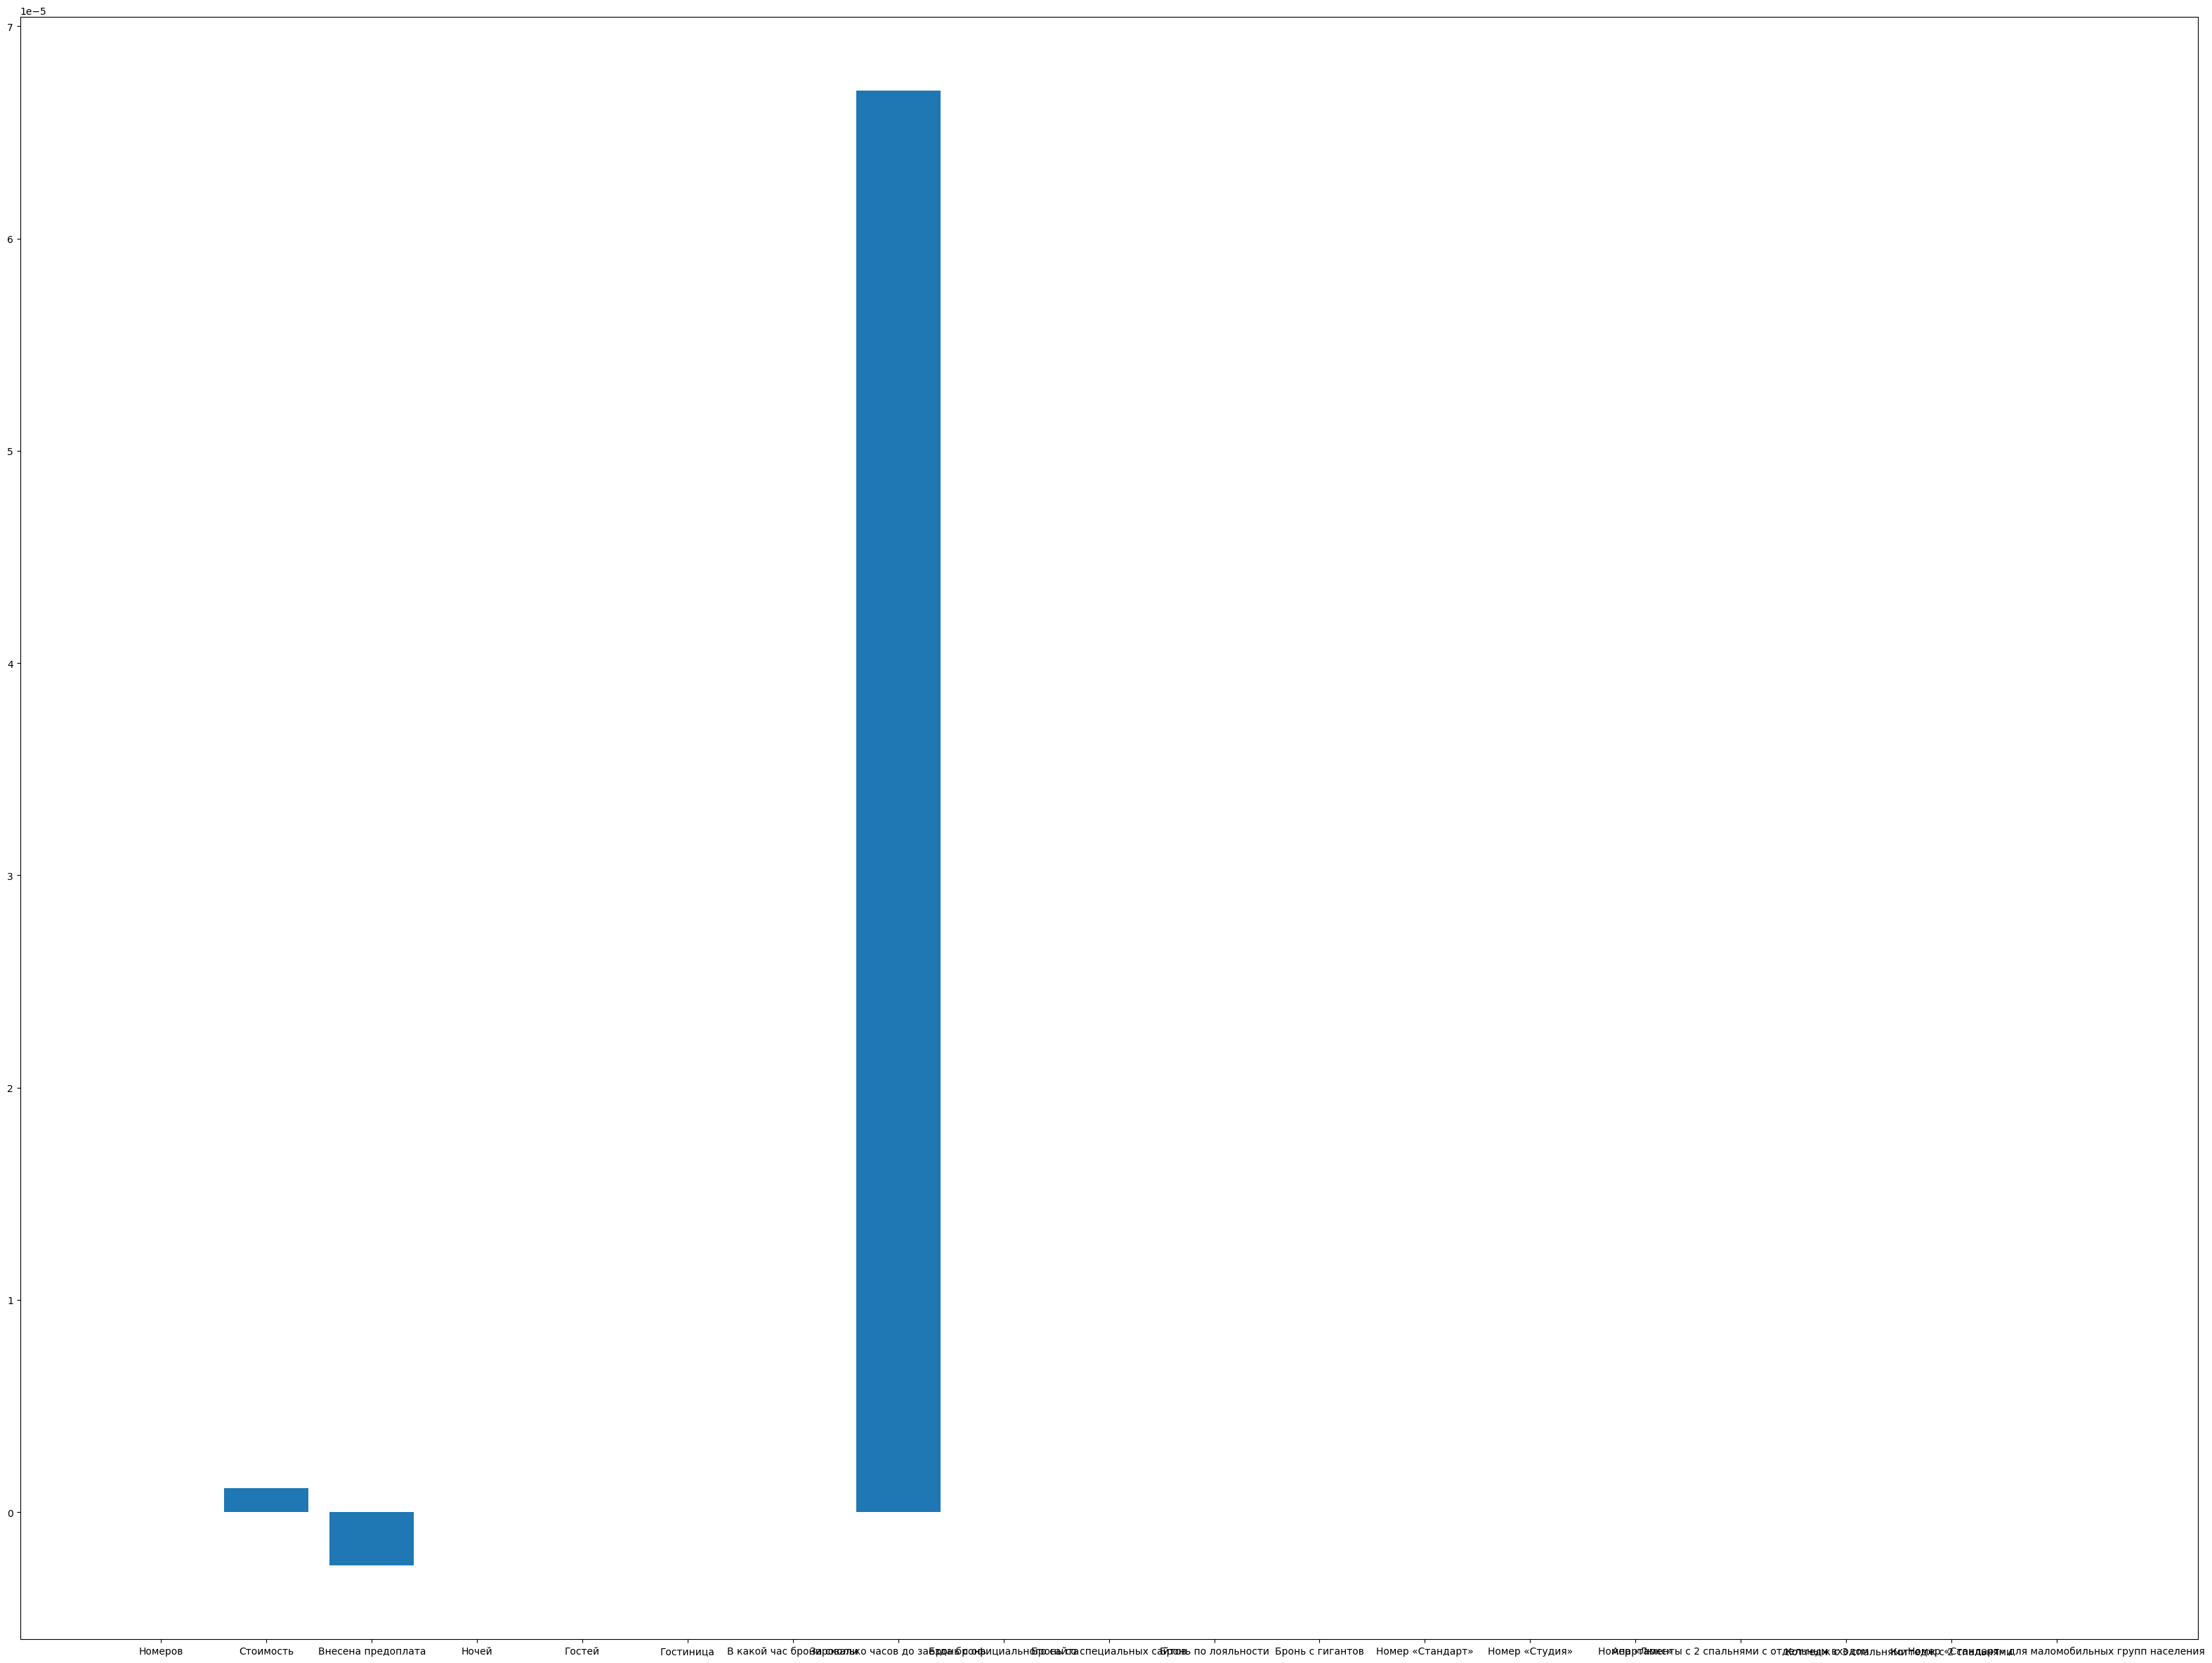

In [116]:
lin_reg = Lasso()
lin_reg.fit(X_train, y_train)
mean_absolute_percentage_error(lin_reg.predict(X_val), y_val)

plt.figure(figsize=(40, 30))
plt.bar(df.columns, lin_reg.coef_.ravel())

In [171]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)
X_val = poly.fit_transform(X_val)
poly.fit(X_poly, y_train)
lin2 = LinearRegression()
lin2.fit(X_poly, y_train)
mean_absolute_percentage_error((lin2.predict(X_val), y_val))

MemoryError: Unable to allocate 9.53 TiB for an array with shape (5235, 250152528) and data type float64

In [ ]:
xx
df1 = pd.read_excel('test (1).xlsx')
clf = DecisionTreeClassifier(max_depth = 2)
clf.fit() 

In [ ]:
df1 = df1.drop(['Unnamed: 0', '№ брони','Способ оплаты'], axis=1)
df1['В какой час бронировали'] = (df1['Дата бронирования'].dt.hour + 2) % 24
df1['За сколько часов до заезда бронь'] = (df1['Заезд'] - df1['Дата бронирования']).dt.total_seconds() // 3600 #насколько рано бронь
df1 = df1.drop(['Дата бронирования', 'Заезд','Выезд'], axis=1) # уберем ненужные столбцы

In [ ]:
for col in ['Источник']:
    df1 = pd.concat([df1, pd.get_dummies(df1[col])], axis=1)
    df1 = df.drop(col, axis=1)
df1['Бронь с официального сайта'] = df1['Официальный сайт']
df1['Бронь со специальных сайтов'] = df1['Bronevik.com(new)'] + df1['booking.com'] + df1['Бронирование из экстранета'] + df1['Zabroniryi.ru'] + df1['OneTwoTrip'] + df1['ostrovok.ru']  + df1['booking.com (Booking.com)']+ df1['Acase.ru (ООО "АКАДЕМ-ОНЛАЙН")']+ df1['Acase.ru (ООО "ПРАНДИУМ")']+ df1['Alean.ru (13.10.2023-02.06.2025)']+ df1['Alean.ru (03.02.2022-31.01.2023)']+ df1['101hotels.com']+ df1['Acase.ru (ООО "КАЛЕЙДОСКОП")']+ df1['Otello'] + df1['expedia.com (A-Hotels.com)']+ df1['Alean.ru (31.10.2023-22.06.2025)'] + df1['Svoy Hotel']+ df1['Alean.ru (20.01.2021-31.01.2022)']
df1['Бронь по лояльности'] = df1['Программа лояльности'] + df1['Cuva']
df1['Бронь с гигантов'] = df1['Яндекс.Путешествия'] + df1['Тинькофф Путешествия'] + df1['Ozon'] + df1['ВКонтакте']

for col in ['Яндекс.Путешествия', 'Официальный сайт', 'Bronevik.com(new)',
       'booking.com', 'Бронирование из экстранета', 'Zabroniryi.ru',
       'OneTwoTrip', 'ostrovok.ru', 'Программа лояльности', 'Cuva',
       'booking.com (Booking.com)', 'Acase.ru (ООО "АКАДЕМ-ОНЛАЙН")',
       'Acase.ru (ООО "ПРАНДИУМ")', 'Alean.ru (13.10.2023-02.06.2025)',
       'Alean.ru (03.02.2022-31.01.2023)', '101hotels.com',
       'Acase.ru (ООО "КАЛЕЙДОСКОП")', 'Alean.ru (16.01.2023-06.09.2024)',
       'Bronevik.com/Bro.Online', 'Тинькофф Путешествия', 'ВКонтакте',
       'Otello', 'expedia.com (A-Hotels.com)', 'Ozon',
       'Alean.ru (31.10.2023-22.06.2025)', 'Svoy Hotel',
       'Alean.ru (20.01.2021-31.01.2022)']:
    df1 = df1.drop(col, axis=1)

In [ ]:
#df1 = df1[df1['Статус брони'] != 'Неподтвержденные']
#df1.loc[df1['Дата отмены'].isna(), 'Факт отмены'] = 0
#df1.loc[df1['Дата отмены'].notna(),'Факт отмены'] = 1
#df1 = df1.drop(['Дата отмены', 'Статус брони'], axis=1)

#df1 = df1[df1['Стоимость'] > 1000]

In [ ]:
categories = np.array(['Номер «Стандарт»', 'Номер «Студия»', 'Номер «Люкс»',
       'Апартаменты с 2 спальнями с отдельным входом',
       'Коттедж с 3 спальнями',
       'Коттедж с 2 спальнями',
       'Номер «Стандарт» для маломобильных групп населения'])

# Create new columns with all zeros
for cat in categories:
    df1[cat] = 0

for index, row in df.iterrows():
    for cat in categories:
        if cat in row['Категория номера']:
            df1.loc[index, cat] = 1  # Set the value to 1 if category is present

for col in ['Категория номера']:
    df1 = df1.drop(col, axis=1)

In [ ]:
print(roc_auc_score(model.predict(xx), yy))


In [135]:
df

,Номеров,Стоимость,Внесена предоплата,Ночей,Источник,Категория номера,Гостей,Гостиница,В какой час бронировали,За сколько часов до заезда бронь
0,1,1.0,1,1,1,1,1,1,1,1.0
1,1,1.0,1,1,1,1,1,1,1,1.0
2,1,1.0,1,1,1,1,1,1,1,1.0
3,1,1.0,1,1,1,1,1,1,1,1.0
4,1,1.0,1,1,1,1,1,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...
26169,1,1.0,1,1,1,1,1,1,1,1.0
26170,1,1.0,1,1,1,1,1,1,1,1.0
26171,1,1.0,1,1,1,1,1,1,1,1.0
26172,1,1.0,1,1,1,1,1,1,1,1.0


In [172]:
# Обучение модели на данных с полиномиальными признаками
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)
X_poly_val = poly.transform(X_val)
lin2 = LinearRegression()
lin2.fit(X_poly_train, y_train)

# Предсказание на валидационных данных и вычисление MAE
y_pred = lin2.predict(X_poly_val)
mae = mean_absolute_error(y_val, y_pred)

print(f'Mean Absolute Error: {mae:.2f}')

C:\Users\ilyas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


ValueError: X has 22366 features, but PolynomialFeatures is expecting 19 features as input.

In [214]:
model = DecisionTreeClassifier(max_depth = 4)
model.fit(X_train, y_train) 
print(roc_auc_score(model.predict(X_val), y_val))

#plt.figure(figsize=(20, 20))
#a=plot_tree(model)
score = model.predict(df.rename(str, axis="columns"))
np.savetxt("tr222.csv", score, delimiter=",")

0.8943445945945945


In [ ]:
1 2 3 7 9 10 11

2 3 2 5 1 1 1 

стоимость 
предоплата 
ночи
заблаговременное планирование
сайты
